# Segmentasi dan Morfologi

Notebook ini mengimplementasikan metode segmentasi dan operasi morfologi untuk citra sel darah tanpa menggunakan library khusus (hanya NumPy dan Matplotlib).

**Disusun oleh:** <br>
Danar Fathurahman <br>
24/538200/PA/22828

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

def segmentasi_thresholding(image, threshold=127):
    binary = np.zeros_like(image)
    binary[image > threshold] = 1
    return binary

def dilasi(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    # Padding image dengan 0
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    result = np.zeros_like(image)

    # Terapkan dilasi
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            # Jika ada intersection antara kernel dan region, set ke 1
            if np.any(region * kernel):
                result[i, j] = 1

    return result

def erosi(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    # Padding image dengan 0
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    result = np.zeros_like(image)

    # Terapkan erosi
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            # Jika semua pixel dalam kernel match dengan region, set ke 1
            if np.all(region[kernel == 1] == 1):
                result[i, j] = 1

    return result

def opening(image, kernel):
    eroded = erosi(image, kernel)
    opened = dilasi(eroded, kernel)
    return opened

def closing(image, kernel):
    dilated = dilasi(image, kernel)
    closed = erosi(dilated, kernel)
    return closed


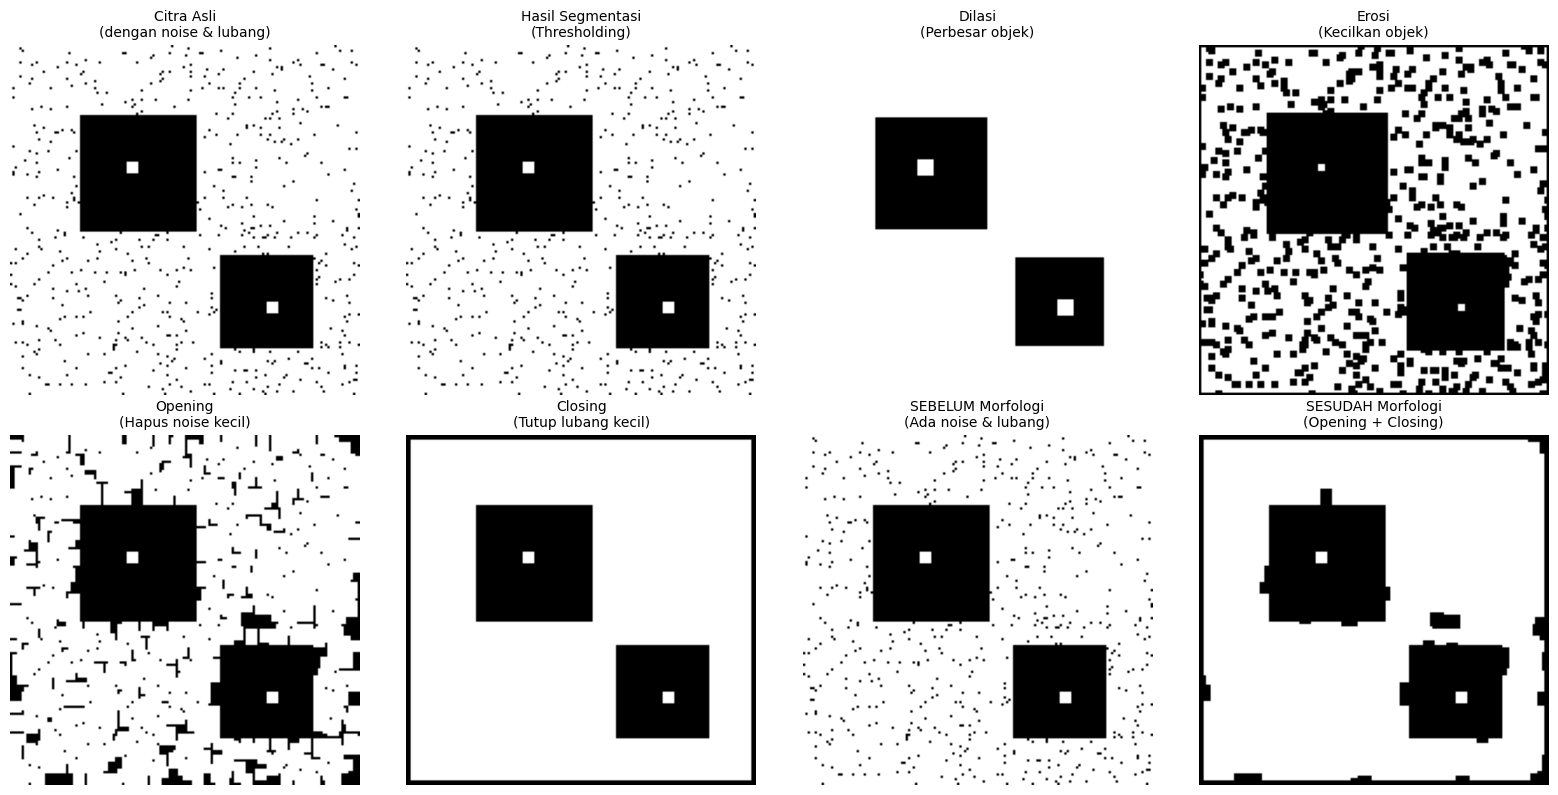


ANALISIS HASIL:

1. SEGMENTASI (Thresholding):
   - Memisahkan objek dari background
   - Masih ada noise dan lubang

2. DILASI:
   - Memperbesar ukuran objek putih
   - Lubang mengecil, tapi noise juga membesar

3. EROSI:
   - Mengecilkan ukuran objek putih
   - Noise hilang, tapi objek juga mengecil

4. OPENING (Erosi → Dilasi):
   - Menghilangkan noise kecil
   - Ukuran objek relatif dipertahankan

5. CLOSING (Dilasi → Erosi):
   - Menutup lubang kecil dalam objek
   - Ukuran objek relatif dipertahankan

6. KOMBINASI (Opening + Closing):
   - Hasil terbaik: noise hilang DAN lubang tertutup
   - Bentuk objek tetap terjaga

Jumlah pixel putih SEBELUM morfologi: 17893.0
Jumlah pixel putih SESUDAH morfologi: 16785.0
Selisih: -1108.0 pixel


In [29]:
# Membuat image sintetis dengan noise
np.random.seed(42)
image_size = 150
img = np.ones((image_size, image_size)) * 255

# Tambahkan objek (persegi dan lingkaran)
img[30:80, 30:80] = 0  # Persegi hitam
img[90:130, 90:130] = 0  # Persegi hitam

# Tambahkan noise (titik-titik kecil)
noise_positions = np.random.rand(image_size, image_size) > 0.97
img[noise_positions] = 0

# Tambahkan lubang kecil dalam objek
img[50:55, 50:55] = 255
img[110:115, 110:115] = 255

# 2. Segmentasi dengan thresholding
binary_img = segmentasi_thresholding(img, threshold=127)

# 3. Buat structuring element (kernel)
kernel_3x3 = np.ones((3, 3), dtype=np.uint8)
kernel_5x5 = np.ones((5, 5), dtype=np.uint8)

# 4. Terapkan operasi morfologi
dilasi_result = dilasi(binary_img, kernel_3x3)
erosi_result = erosi(binary_img, kernel_3x3)
opening_result = opening(binary_img, kernel_5x5)
closing_result = closing(binary_img, kernel_5x5)

# 5. Visualisasi hasil
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Baris 1: Proses awal
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Citra Asli\n(dengan noise & lubang)', fontsize=10)
axes[0, 0].axis('off')

axes[0, 1].imshow(binary_img, cmap='gray')
axes[0, 1].set_title('Hasil Segmentasi\n(Thresholding)', fontsize=10)
axes[0, 1].axis('off')

axes[0, 2].imshow(dilasi_result, cmap='gray')
axes[0, 2].set_title('Dilasi\n(Perbesar objek)', fontsize=10)
axes[0, 2].axis('off')

axes[0, 3].imshow(erosi_result, cmap='gray')
axes[0, 3].set_title('Erosi\n(Kecilkan objek)', fontsize=10)
axes[0, 3].axis('off')

# Baris 2: Operasi lanjutan
axes[1, 0].imshow(opening_result, cmap='gray')
axes[1, 0].set_title('Opening\n(Hapus noise kecil)', fontsize=10)
axes[1, 0].axis('off')

axes[1, 1].imshow(closing_result, cmap='gray')
axes[1, 1].set_title('Closing\n(Tutup lubang kecil)', fontsize=10)
axes[1, 1].axis('off')

# Perbandingan: Sebelum vs Sesudah morfologi
axes[1, 2].imshow(binary_img, cmap='gray')
axes[1, 2].set_title('SEBELUM Morfologi\n(Ada noise & lubang)', fontsize=10)
axes[1, 2].axis('off')

# Kombinasi: Opening + Closing untuk hasil terbaik
best_result = closing(opening_result, kernel_5x5)
axes[1, 3].imshow(best_result, cmap='gray')
axes[1, 3].set_title('SESUDAH Morfologi\n(Opening + Closing)', fontsize=10)
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

# 6. Analisis hasil
print("\n" + "="*60)
print("ANALISIS HASIL:")
print("="*60)
print("\n1. SEGMENTASI (Thresholding):")
print("   - Memisahkan objek dari background")
print("   - Masih ada noise dan lubang\n")

print("2. DILASI:")
print("   - Memperbesar ukuran objek putih")
print("   - Lubang mengecil, tapi noise juga membesar\n")

print("3. EROSI:")
print("   - Mengecilkan ukuran objek putih")
print("   - Noise hilang, tapi objek juga mengecil\n")

print("4. OPENING (Erosi → Dilasi):")
print("   - Menghilangkan noise kecil")
print("   - Ukuran objek relatif dipertahankan\n")

print("5. CLOSING (Dilasi → Erosi):")
print("   - Menutup lubang kecil dalam objek")
print("   - Ukuran objek relatif dipertahankan\n")

print("6. KOMBINASI (Opening + Closing):")
print("   - Hasil terbaik: noise hilang DAN lubang tertutup")
print("   - Bentuk objek tetap terjaga")
print("="*60)

# Hitung perbedaan pixel
diff_before = np.sum(binary_img)
diff_after = np.sum(best_result)
print(f"\nJumlah pixel putih SEBELUM morfologi: {diff_before}")
print(f"Jumlah pixel putih SESUDAH morfologi: {diff_after}")
print(f"Selisih: {diff_after - diff_before} pixel")

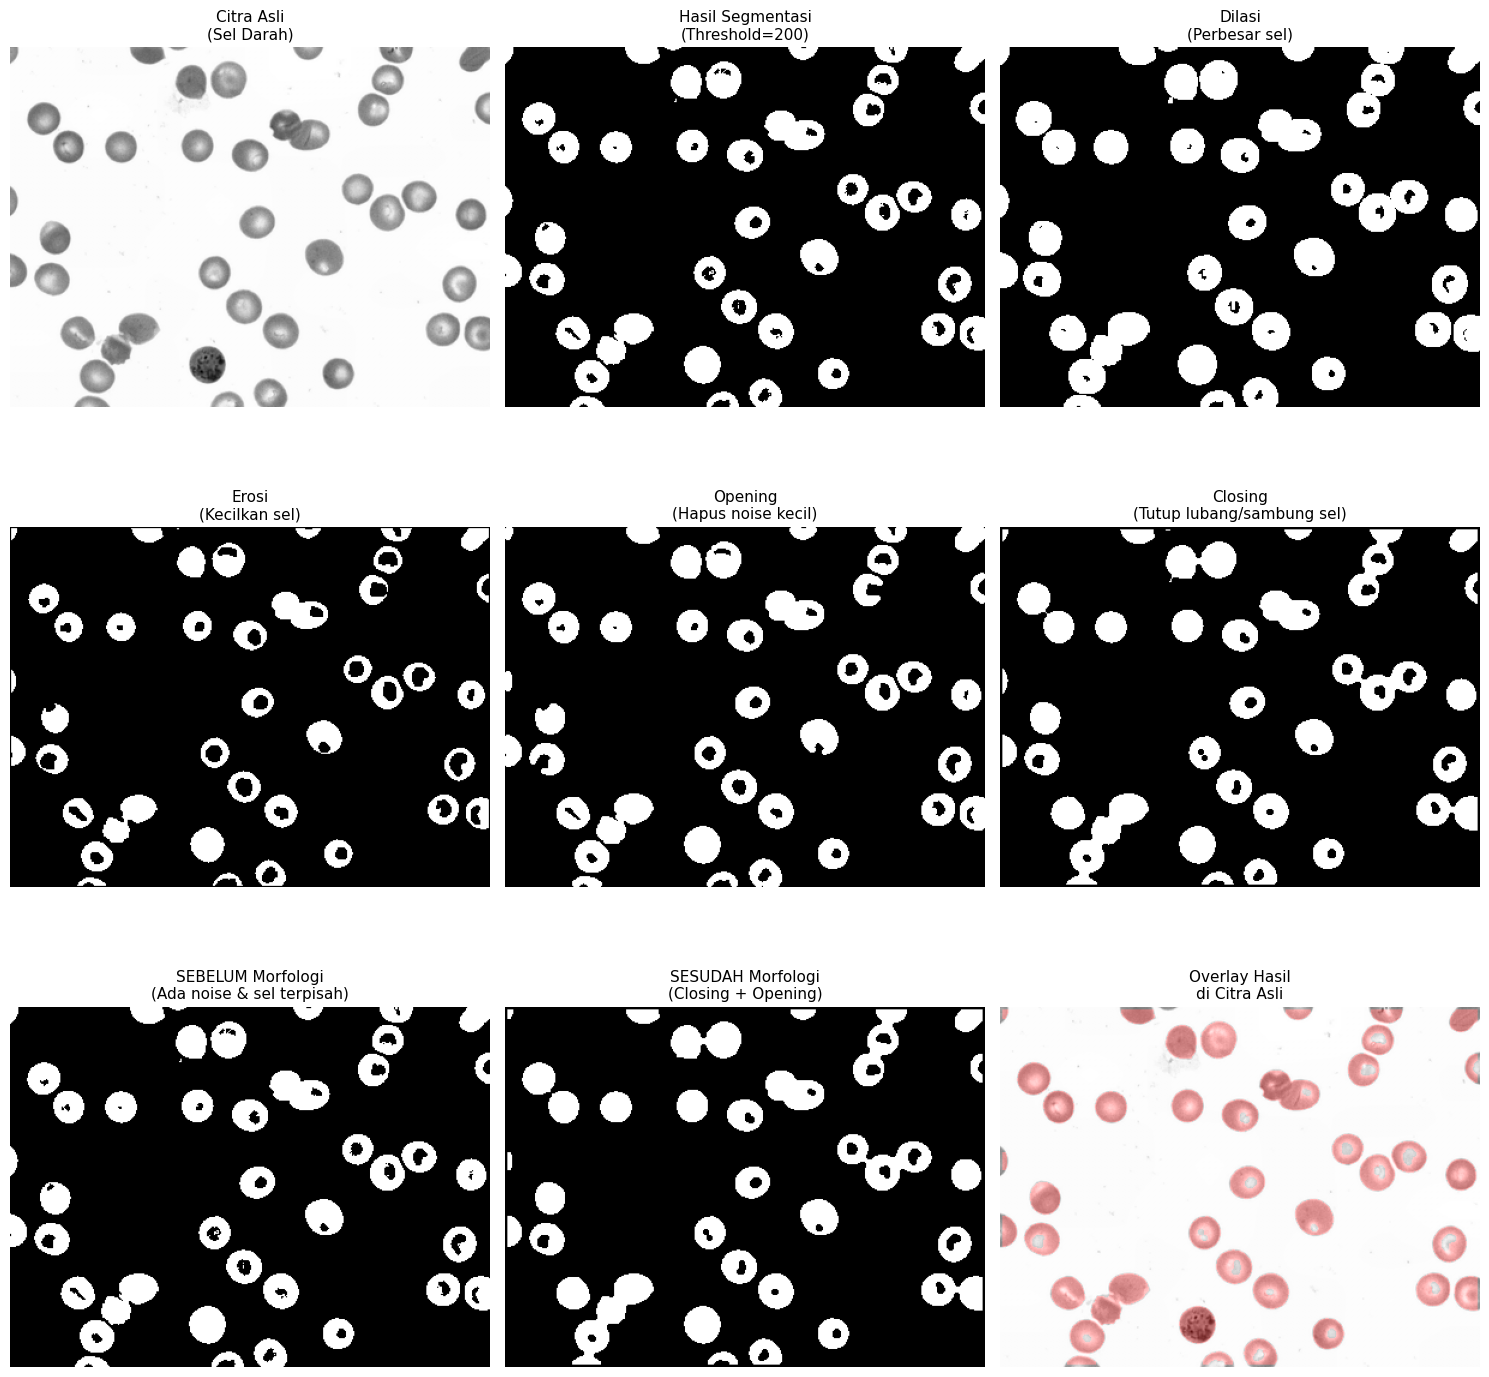


ANALISIS HASIL - CITRA SEL DARAH:

Ukuran citra: 300 x 400 pixels
Threshold yang digunakan: 200

1. SEGMENTASI (Thresholding):
   - Memisahkan sel dari background putih
   - Sel yang lebih gelap menjadi objek putih

2. DILASI:
   - Memperbesar ukuran sel
   - Sel yang berdekatan bisa menyatu

3. EROSI:
   - Mengecilkan ukuran sel
   - Memisahkan sel yang menempel

4. OPENING (Erosi → Dilasi):
   - Menghilangkan noise/partikel kecil
   - Memisahkan sel yang menempel sedikit

5. CLOSING (Dilasi → Erosi):
   - Menutup lubang dalam sel
   - Menyambung bagian sel yang terputus

6. KOMBINASI (Closing + Opening):
   - Hasil optimal: sel terdeteksi dengan baik
   - Noise hilang, bentuk sel terjaga

PERHITUNGAN OBJEK:
   Sebelum morfologi: 51 objek terdeteksi
   Sesudah morfologi: 32 objek terdeteksi


In [30]:
# 1. Baca image
img_pil = Image.open('/content/blood_cell.png')

# Konversi ke grayscale
if img_pil.mode != 'L':
    img_pil = img_pil.convert('L')

# Konversi ke numpy array
img = np.array(img_pil)

# 2. Segmentasi dengan thresholding
threshold_value = 200
binary_img = segmentasi_thresholding(img, threshold=threshold_value)

# Inverse binary (karena sel lebih gelap dari background)
binary_img = 1 - binary_img

# 3. Buat structuring element (kernel)
kernel_3x3 = np.ones((3, 3), dtype=np.uint8)
kernel_5x5 = np.ones((5, 5), dtype=np.uint8)

# Kernel berbentuk disk untuk hasil lebih baik pada sel bulat
kernel_disk = np.array([[0, 1, 1, 1, 0],
                         [1, 1, 1, 1, 1],
                         [1, 1, 1, 1, 1],
                         [1, 1, 1, 1, 1],
                         [0, 1, 1, 1, 0]], dtype=np.uint8)

# 4. Menerapkan operasi morfologi
dilasi_result = dilasi(binary_img, kernel_3x3)
erosi_result = erosi(binary_img, kernel_3x3)
opening_result = opening(binary_img, kernel_disk)  # Gunakan disk kernel
closing_result = closing(binary_img, kernel_disk)  # Gunakan disk kernel

# 5. Visualisasi hasil
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Baris 1: Proses awal
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Citra Asli\n(Sel Darah)', fontsize=11)
axes[0, 0].axis('off')

axes[0, 1].imshow(binary_img, cmap='gray')
axes[0, 1].set_title(f'Hasil Segmentasi\n(Threshold={threshold_value})', fontsize=11)
axes[0, 1].axis('off')

axes[0, 2].imshow(dilasi_result, cmap='gray')
axes[0, 2].set_title('Dilasi\n(Perbesar sel)', fontsize=11)
axes[0, 2].axis('off')

# Baris 2: Operasi dasar
axes[1, 0].imshow(erosi_result, cmap='gray')
axes[1, 0].set_title('Erosi\n(Kecilkan sel)', fontsize=11)
axes[1, 0].axis('off')

axes[1, 1].imshow(opening_result, cmap='gray')
axes[1, 1].set_title('Opening\n(Hapus noise kecil)', fontsize=11)
axes[1, 1].axis('off')

axes[1, 2].imshow(closing_result, cmap='gray')
axes[1, 2].set_title('Closing\n(Tutup lubang/sambung sel)', fontsize=11)
axes[1, 2].axis('off')

# Baris 3: Perbandingan final
axes[2, 0].imshow(binary_img, cmap='gray')
axes[2, 0].set_title('SEBELUM Morfologi\n(Ada noise & sel terpisah)', fontsize=11)
axes[2, 0].axis('off')

# Kombinasi: Opening untuk hasil lebih baik
best_result = opening(closing_result, kernel_3x3)
axes[2, 1].imshow(best_result, cmap='gray')
axes[2, 1].set_title('SESUDAH Morfologi\n(Closing + Opening)', fontsize=11)
axes[2, 1].axis('off')

# Overlay hasil segmentasi pada citra asli
overlay = np.stack([img, img, img], axis=-1).astype(float) / 255.0
overlay[:, :, 0] += best_result * 0.3
overlay = np.clip(overlay, 0, 1)
axes[2, 2].imshow(overlay)
axes[2, 2].set_title('Overlay Hasil\ndi Citra Asli', fontsize=11)
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

# 6. Analisis hasil dan hitung jumlah sel
print("\n" + "="*60)
print("ANALISIS HASIL - CITRA SEL DARAH:")
print("="*60)
print(f"\nUkuran citra: {img.shape[0]} x {img.shape[1]} pixels")
print(f"Threshold yang digunakan: {threshold_value}\n")

print("1. SEGMENTASI (Thresholding):")
print("   - Memisahkan sel dari background putih")
print("   - Sel yang lebih gelap menjadi objek putih\n")

print("2. DILASI:")
print("   - Memperbesar ukuran sel")
print("   - Sel yang berdekatan bisa menyatu\n")

print("3. EROSI:")
print("   - Mengecilkan ukuran sel")
print("   - Memisahkan sel yang menempel\n")

print("4. OPENING (Erosi → Dilasi):")
print("   - Menghilangkan noise/partikel kecil")
print("   - Memisahkan sel yang menempel sedikit\n")

print("5. CLOSING (Dilasi → Erosi):")
print("   - Menutup lubang dalam sel")
print("   - Menyambung bagian sel yang terputus\n")

print("6. KOMBINASI (Closing + Opening):")
print("   - Hasil optimal: sel terdeteksi dengan baik")
print("   - Noise hilang, bentuk sel terjaga")
print("="*60)

# Hitung estimasi jumlah sel
def hitung_komponen(binary_image):
    labeled = np.zeros_like(binary_image, dtype=int)
    label_num = 0
    h, w = binary_image.shape

    for i in range(h):
        for j in range(w):
            if binary_image[i, j] == 1 and labeled[i, j] == 0:
                # Mulai flood fill sederhana
                label_num += 1
                stack = [(i, j)]
                while stack:
                    y, x = stack.pop()
                    if y < 0 or y >= h or x < 0 or x >= w:
                        continue
                    if binary_image[y, x] == 1 and labeled[y, x] == 0:
                        labeled[y, x] = label_num
                        stack.extend([(y-1, x), (y+1, x), (y, x-1), (y, x+1)])

    return label_num

jumlah_sebelum = hitung_komponen(binary_img)
jumlah_sesudah = hitung_komponen(best_result)

print(f"\nPERHITUNGAN OBJEK:")
print(f"   Sebelum morfologi: {jumlah_sebelum} objek terdeteksi")
print(f"   Sesudah morfologi: {jumlah_sesudah} objek terdeteksi")